In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import cPickle
import cv2

import CarDetectorFunc as cd

In [2]:
loaded_model = cPickle.load(open('model/0330_svm_model.p', 'rb'))
loaded_model

{'X_scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'hyperconfig': <CarDetectorFunc.Config at 0x104db85d0>,
 'svc': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0),
 'svd_subspace': None}

In [3]:
config = loaded_model['hyperconfig']
config.show()

color space   : YCrCb
--- spatial-bining-color ---
use svd       : False
svd K         : 75
spatial size  : (32, 32)
--- color-histogram ----
hist bins     : 32
hist range    : (0, 256)
--- HOG ---
orient        : 7
pix per cell  : 8
cell per block: 2
hog channel   : ALL


In [4]:
svc = loaded_model['svc']
X_scaler = loaded_model['X_scaler']
svd_subspace = loaded_model['svd_subspace']

In [5]:
import glob
test_imgs_path = glob.glob('../test_images/*.jpg')
test_imgs_path

['../test_images/bbox-example-image.jpg',
 '../test_images/test1.jpg',
 '../test_images/test2.jpg',
 '../test_images/test3.jpg',
 '../test_images/test4.jpg',
 '../test_images/test5.jpg',
 '../test_images/test6.jpg']

(720, 1280, 3)


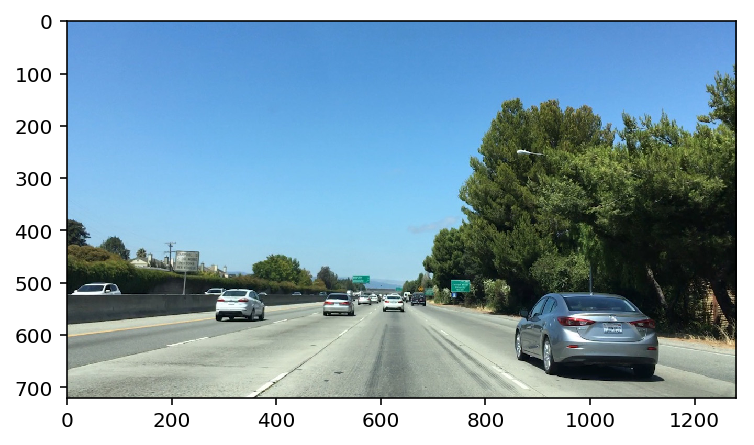

In [6]:
test_img = mpimg.imread(test_imgs_path[0])
print(test_img.shape)
plt.imshow(test_img)

In [7]:
roi = (400, 700)  # (ystart, ystop)
scaler_list = [1, 1.2, 1.4, 1.6, 1.8, 2, 2.2]

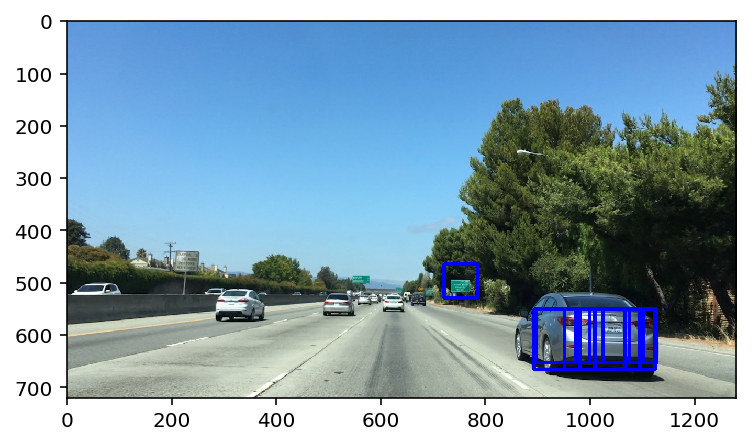

In [8]:
hot_windows = cd.find_cars_multi_scaler(image=test_img,
                                        svm_model=loaded_model,
                                        scaler_list=scaler_list,
                                        roi = roi,
                                        vis=True)
# hot_windows

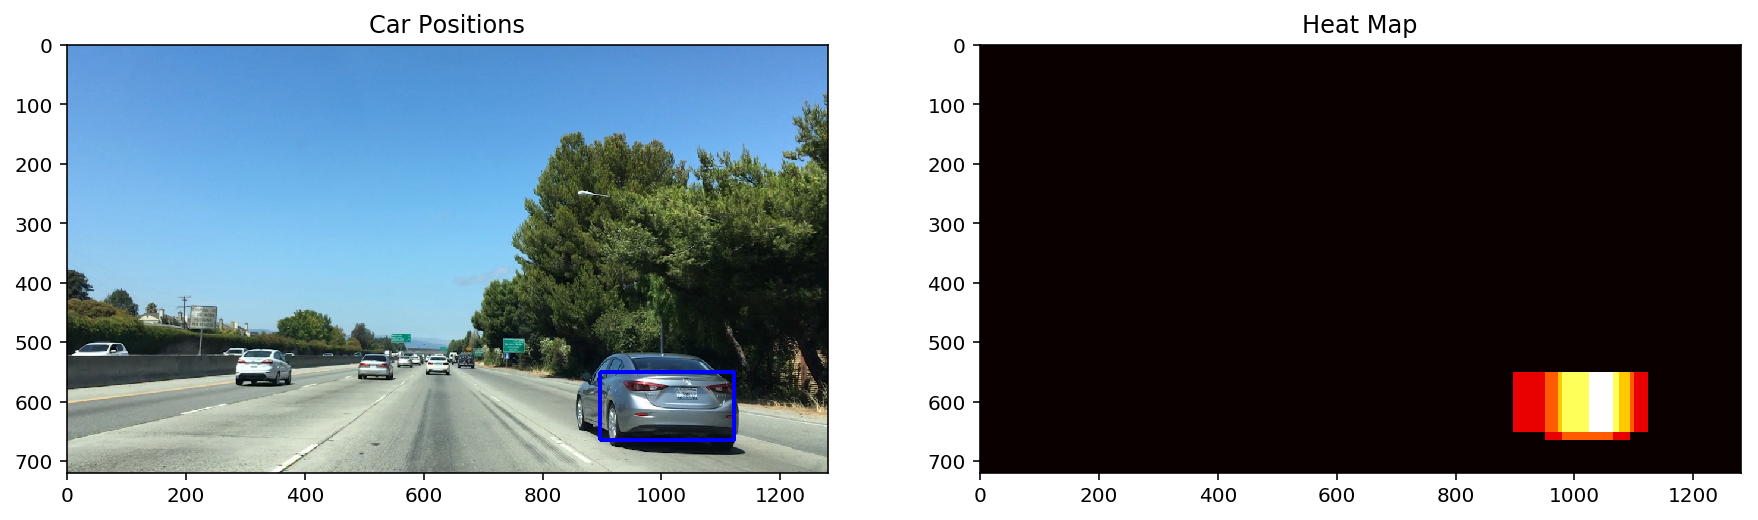

In [9]:
bboxes, heatmap = cd.get_heatmap(img=test_img,
                                 hot_windows=hot_windows,
                                 threshold=1, vis=True)

In [10]:
nframes = 1
smooth_thres = 1
smooth_average = 0
heat_box_frames = [0] * nframes
counter = 0
def process_image(img):
    global counter
    global heat_box_frames
    countFrame = counter % nframes
    #Find rectangles for one image
    hot_windows = cd.find_cars_multi_scaler(image=img,
                                            svm_model=loaded_model,
                                            scaler_list=scaler_list,
                                            roi=roi)

    #Find heatmap single image
    thres = smooth_thres
    bboxes1, _ = cd.get_heatmap(img, hot_windows, thres)

    #Store the rectangles of the frame
#     print countFrame
    heat_box_frames[countFrame] = bboxes1
    
    #Sum rectangles of the nframes
    bboxes2 = []
    for bboxes in heat_box_frames:
        if bboxes == 0:
            continue
        bboxes2.extend(bboxes)
    
    #Find heatmap of average
    thres = smooth_average
    bboxes, heatmap = cd.get_heatmap(img, bboxes2, thres)
    
    #Merge heatmap with image
    heat_y, heat_x = heatmap.shape
    heat_y = int(heat_y / 4)
    heat_x = int(heat_x / 4)
    
    heatmap = cv2.resize(heatmap, (heat_x, heat_y))
    _max = np.max(heatmap)
    if _max != 0:
        heatmap = heatmap / _max * 255
    dimg = cd.draw_boxes(img, bboxes, thick=4)

    dimg[0:heat_y, 0:heat_x, :] = 0
    dimg[0:heat_y, 0:heat_x, 0] = heatmap
    
    cv2.putText(dimg,"Heat Map", (102,25), cv2.FONT_HERSHEY_SIMPLEX, .8,(255,255,255), 1)

    counter += 1
    return dimg

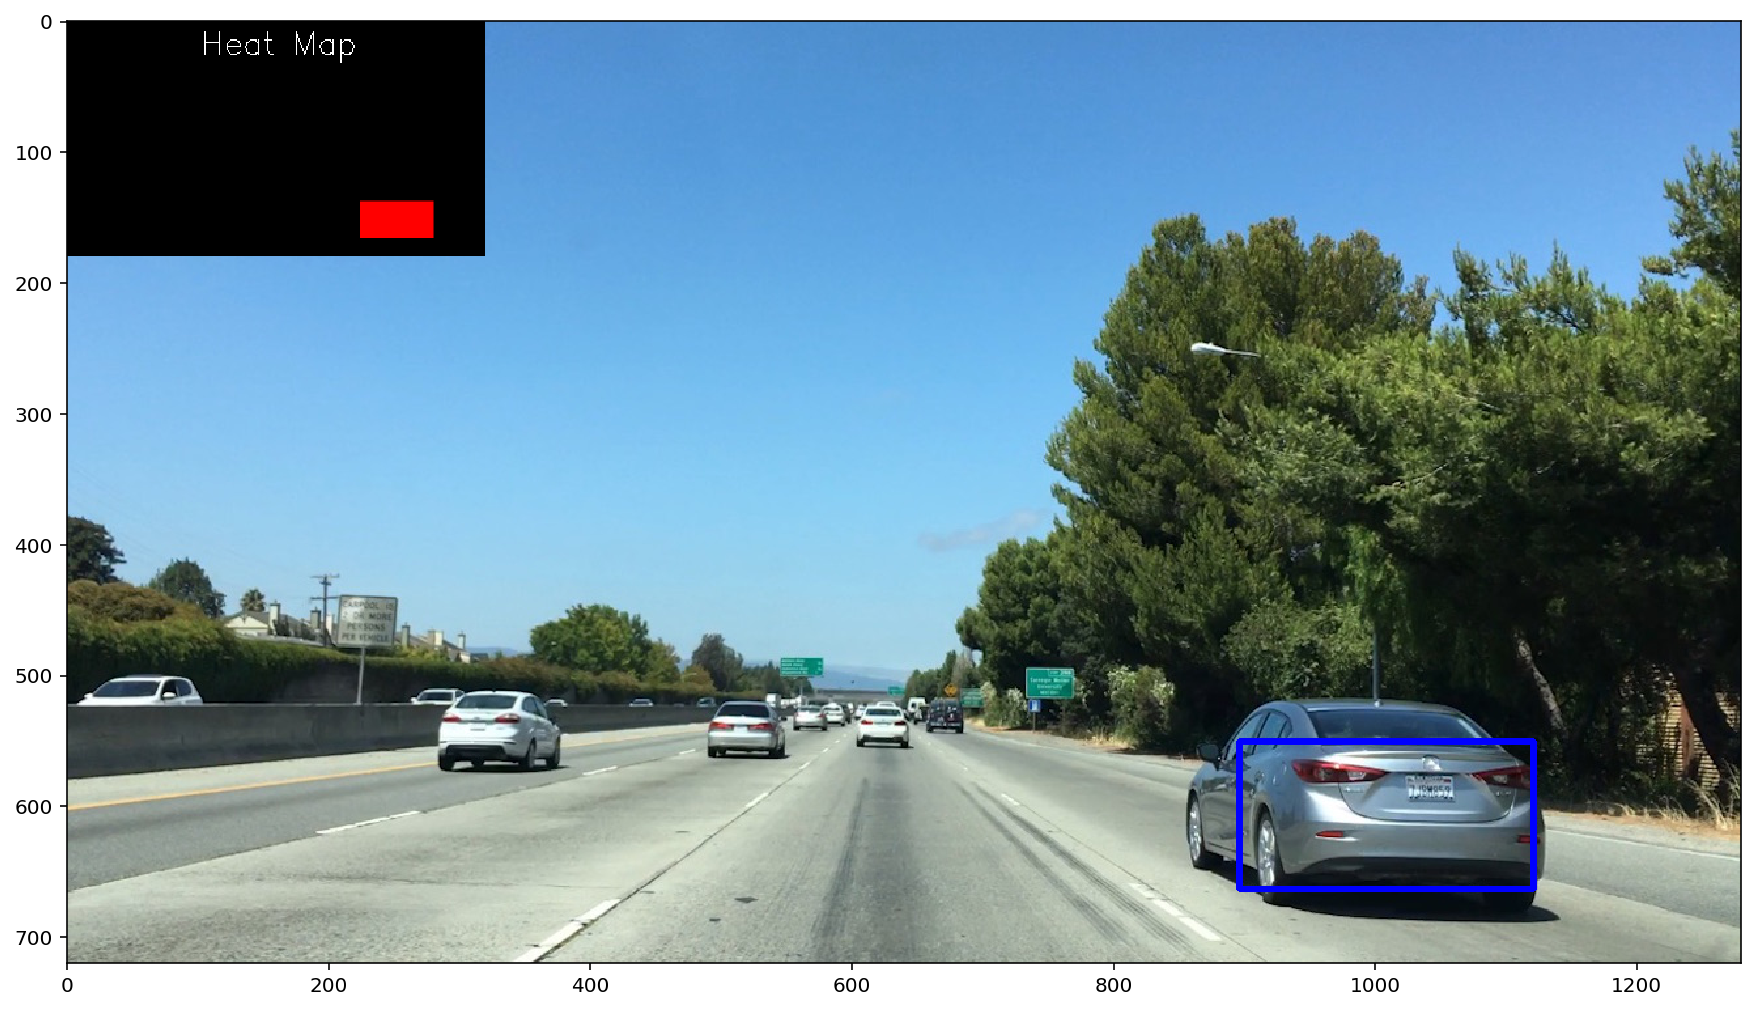

In [11]:
final_img = process_image(test_img)
plt.figure(figsize=(15,10))
plt.imshow(final_img)

# Video

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

/Users/apple/anaconda/envs/py2/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [17]:
#Create video file pipeline
counter=0
nframes = 10
smooth_thres =1
smooth_average=2
heat_box_frames = [0] * nframes

output = 'out_test_video.mp4'
#clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("../test_video.mp4")#.subclip(40,44)

out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)



MoviePy: building video file out_test_video.mp4
----------------------------------------

Writing video into out_test_video.mp4
Done writing video in out_test_video.mp4 !                           
Your video is ready !
CPU times: user 1min 11s, sys: 1.25 s, total: 1min 13s
Wall time: 40 s


In [18]:
#Create video file pipeline
counter=0
nframes = 12
smooth_thres = 1
smooth_average = 3
heat_box_frames = [0] * nframes

output = 'out_project_video.mp4'
#clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("../project_video.mp4")#.subclip(40,44)

out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)



MoviePy: building video file out_project_video.mp4
----------------------------------------

Writing video into out_project_video.mp4
Done writing video in out_project_video.mp4 !                            
Your video is ready !
CPU times: user 40min 47s, sys: 53.8 s, total: 41min 40s
Wall time: 22min 38s
